# Lab 3
## Task 3: Compute Homography from Points (40 pts)

We are given points correspondences from two images. We want to compute the homography. As an example we will use the same two images as in previous tasks.

In [1]:
from IPython.display import Image
import cv2
import numpy as np

train_img = cv2.imread('images/green.png')
poster_img = cv2.imread('images/poster.png')
(ph,pw,pc) = poster_img.shape

poster_p = np.array([[0, 0, 1], [0, pw, 1], [ph, pw, 1], [ph, 0, 1]])
train_p = np.array([[170, 95, 1], [171,238, 1], [233,235, 1], [239,94, 1]])

Let consider the pair of corresponding points. We want to find matrix $H$:

$$
\begin{bmatrix}
  H_{11} & H_{12} & H_{13} \\
  H_{21} & H_{22} & H_{23} \\
  H_{31} & H_{32} & H_{33} \\
\end{bmatrix}
\begin{bmatrix}
  x_1 \\
  y_1 \\
  z_1 \\
\end{bmatrix}
=
\begin{bmatrix}
  x_2 \\
  y_2 \\
  z_2 \\
\end{bmatrix}
$$

let $x' = x/z$ and $y' = y/z$, then:

$$ x_2' = \frac{H_{11}x_1+H_{12}y_1+H_{13}z_1}{H_{31}x_1+H_{32}y_1+H_{33}z_1}$$

$$ y_2' = \frac{H_{21}x_1+H_{22}y_1+H_{23}z_1}{H_{31}x_1+H_{32}y_1+H_{33}z_1}$$

We can now rearrange those two equation into:

$$ a_x^T\mathbf{h} = 0$$
$$ a_y^T\mathbf{h} = 0$$

where

$$ h = (H_{11},H_{12},H_{13},H_{21},H_{22},H_{23},H_{31},H_{32},H_{33})^T $$

$$ a_x = (-x_1,-y_1,-z_1,0,0,0,x_2'x_1,x_2'y_1,x_2'z_1)^T $$
$$ a_y = (0,0,0,-x_1,-y_1,-z_1,y_2'x_1,y_2'y_1,y_2'z_1)^T $$

Finally given a set of corresponding points, we can form the following linear system of equations,

$$
A\mathbf{h} = 0
$$

where

$$
A= \begin{pmatrix}
  a_{x_1}^T \\
  a_{y_1}^T \\
  \vdots \\
  a_{x_N}^T \\
  a_{y_N}^T \\
\end{pmatrix}
$$

We solve it using Singular Value Decomposition (SVD). From the SVD we take the "right singular vector" (a column from V) which corresponds to the smallest singular value.

In [2]:
def find_homography(p1, p2):
    A = np.zeros((8, 9), np.float32)
    for i in range(0,4): 
        A[2*i] 	= [-p1[i,0],-p1[i,1],-p1[i,2],0,0,0,(p2[i,0]/p2[i,2])*p1[i,0],(p2[i,0]/p2[i,2])*p1[i,1],(p2[i,0]/p2[i,2])*p1[i,2]]
        A[2*i+1]= [0,0,0,-p1[i,0],-p1[i,1],-p1[i,2],(p2[i,1]/p2[i,2])*p1[i,0],(p2[i,1]/p2[i,2])*p1[i,1],(p2[i,1]/p2[i,2])*p1[i,2]]

    U, s, V = np.linalg.svd(A, full_matrices=True)
    H = V[8,:]
    return H.reshape((3,3))

For testing our homography we need code from previous tasks

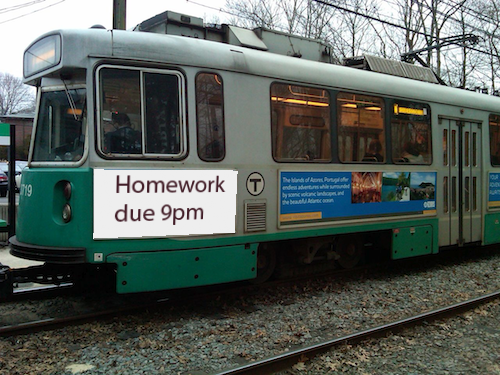

In [3]:
from homography import *


H = find_homography(train_p,poster_p)

output_img = apply_homography_bi(train_img, poster_img, H)
output_path = 'output/trainBI_myHomography.png'
cv2.imwrite(output_path,output_img)
Image(output_path)

## Task 4: Bounding Box (20 pts)

Now we will estimate the size of output image after applying a homography. As before we are given set of images and pairs of corresponding points (from Pano-UI/click.html).


In [4]:
img1 = cv2.imread('images/science-1.jpg')
img2 = cv2.imread('images/science-2.jpg')

pts1 = np.array([[338, 105, 1],[307, 105, 1],[305, 37, 1],[356, 13, 1]])
pts2 = np.array([[326, 306, 1],[296, 304, 1],[297, 235, 1],[347, 217, 1]])

H = find_homography(pts1, pts2)

If we use img1 as an output canvas we will get something like this:

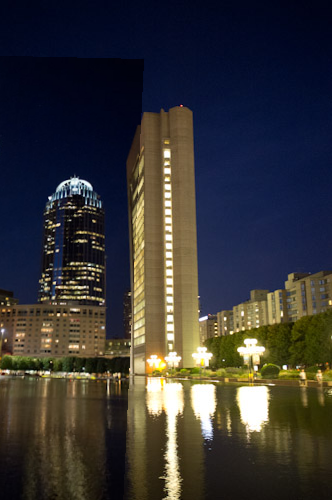

In [5]:
output_img = apply_homography_bi(img1, img2, H)
output_path = 'output/science_cropped.png'
cv2.imwrite(output_path,output_img)
Image(output_path)

We have to compute bounding box for those transformed images. As an output of this function we get shape of new image (bonding-box) and offset (y,x):

In [6]:
def find_bounding_box((h1,w1,c1), (h2,w2,c2), H):
    X = [0,w1]
    Y = [0,h1]
    H_inv = np.linalg.inv(H)
    corners = [(0,0), (0,w2), (h2,0), (h2,w2)]
    for (y,x) in corners:
        (new_y, new_x) = calculate_coords(y,x,H_inv)
        X.append(int(new_x))
        Y.append(int(new_y))
    
    new_shape = (max(Y)-min(Y), max(X)-min(X), c1)
    offset = (0-min(Y), 0-min(X))
    
    return new_shape, offset

As we have that function we can apply homography on those images on new canvas and move them according to offset. We have to add some code to `apply_homography` function:

In [7]:
def apply_homography_bi3(img1, img2, H, output_shape=None, offset=(0,0)):
    if(output_shape):
        output_img = np.zeros(output_shape, img1.dtype)
    else:
        output_img = np.zeros_like(img1)

    (height, width, channels) = output_img.shape
    (h2, w2, c2) = img2.shape
    (h1, w1, c1) = img1.shape
    (offset_y, offset_x) = offset
    
    for y in range(0, height):
        for x in range(0, width):
            (y_pos, x_pos) = calculate_coords(y-offset_y, x-offset_x, H)
            y1 = int(y_pos)
            y2 = y1+1
            x1 = int(x_pos)
            x2 = x1+1

            if  between(y1, 0, h2) \
            and between(x1, 0, w2) \
            and between(y2, 0, h2) \
            and between(x2, 0, w2):
                for i in range(0, channels):
                    output_img[y, x, i] = bilinear_interpolation(
                        y_pos,x_pos,
                        y1,y2,x1,x2,
                        img2[y1, x1, i],
                        img2[y1, x2, i],
                        img2[y2, x1, i],
                        img2[y2, x2, i]
                    )
            else:
                if between(y-offset_y, 0, h1) \
                and between(x-offset_x, 0, w1):
                    output_img[y, x] = img1[y-offset_y, x-offset_x]
    return output_img

Now we can finally apply our homography:

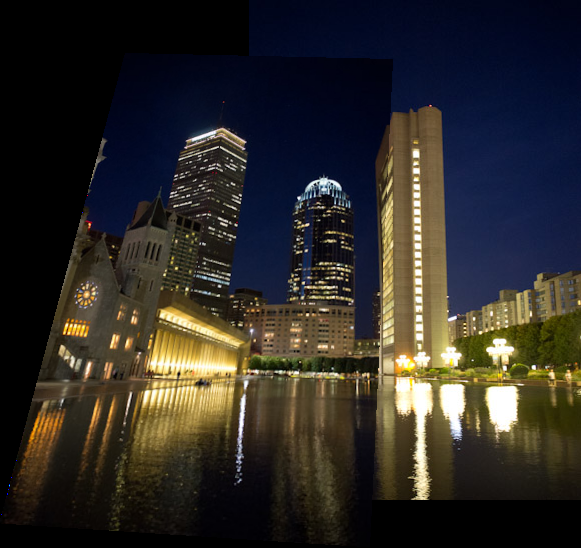

In [8]:
output_shape, offset = find_bounding_box(img1.shape, img2.shape, H)
output_img = apply_homography_bi3(img1, img2, H, output_shape, offset)
output_path = 'output/science.png'
cv2.imwrite(output_path,output_img)
Image(output_path)